## Home assignment 06: Gradient boosting with MSE

Please, fill the lines in the code below.
This is a simplified version of `BoostingRegressor` from `sklearn`. Please, notice, that `sklearn` API is **not preserved**.

Your algorithm should be able to train different numbers of instances of the same model class. Every target is computed according to the loss function gradient. In this particular case, loss is computed for MSE.

The model should be passed as model class with no explicit parameters and no parentheses.

Example:
```
import numpy as np
from sklearn.tree import DecisionTreeRegressor

boosting_regressor = SimplifiedBoostingRegressor()    
boosting_regressor.fit(DecisionTreeRegressor, X, y, 100, 0.5, 10)


```

In [3]:
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [108]:
class SimplifiedBoostingRegressor:
    def __init__(self):
        pass
        
    @staticmethod
    def loss(targets, predictions):
        loss = np.mean((targets - predictions)**2)
        return loss
    
    @staticmethod
    def loss_gradients(targets, predictions):
        gradients = - 2 * (targets - predictions)
        assert gradients.shape == targets.shape
        return gradients
        
        
    def fit(self, model_constructor, data, targets, num_steps=10, lr=0.1, max_depth=5, verbose=False):
        '''
        Fit sequence of models on the provided data.
        Model constructor with no parameters (and with no ()) is passed to this function.
        If 
        
        example:
        
        boosting_regressor = SimplifiedBoostingRegressor()    
        boosting_regressor.fit(DecisionTreeRegressor, X, y, 100, 0.5, 10)
        '''
        new_targets = targets
        self.models_list = []
        self.lr = lr
        self.loss_log = []
        for step in range(num_steps):
            try:
                model = model_constructor(max_depth=max_depth)
            except TypeError:
                print('max_depth keyword is not found. Ignoring')
                model = model_constructor()
            self.models_list.append(model.fit(data, new_targets))
            predictions = self.predict(data)
            self.loss_log.append(self.loss(targets, predictions))
            gradients = self.loss_gradients(targets, predictions)
            new_targets = -gradients
        if verbose:
            print('Finished! Loss=', self.loss_log[-1])
        return self
            
    def predict(self, data, f = False):
        predictions = np.zeros(len(data))
        for model in self.models_list:
            predictions += model.predict(data)*self.lr
        return predictions

### Local tests:

#### Overfitting tests:

In [66]:
class GradientBoostingMSE:
    def __init__(
        self, n_estimators, learning_rate=0.1, max_depth=5, feature_subsample_size=None,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        learning_rate : float
            Use alpha * learning_rate instead of alpha

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.
        """
        self.n_estimators = n_estimators
        self.lr = learning_rate
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size \
            if feature_subsample_size is not None else 1. / 3
        self.params = trees_parameters

    @staticmethod
    def loss_gradients(targets, predictions):
        gradients = -  (targets - predictions)
        return gradients


    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects
        """
        n, m = X.shape
        self.trees = []
        self.indeces_for_trees = []
        self.alphas = []
        
        ensemble_preds = np.zeros(n)
        for _ in range(self.n_estimators):
            sub_features_ind = np.random.choice(np.arange(m), int(self.feature_subsample_size * m), replace=False)
            subset_X = X[:, sub_features_ind]
            self.indeces_for_trees.append(sub_features_ind)

            gradients = self.loss_gradients(y, ensemble_preds)
            tree = DecisionTreeRegressor(max_depth=self.max_depth).fit(subset_X, -gradients)

            self.trees.append(tree)
            cur_tree_preds = tree.predict(subset_X)
            alpha = minimize_scalar(lambda x: np.sum(ensemble_preds + x*cur_tree_preds - y)**2).x
            self.alphas.append(alpha)
            
            ensemble_preds = ensemble_preds + alpha*self.lr*cur_tree_preds
        print(self.alphas)

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        ans = np.zeros(X.shape[0])
        if len(self.trees) > 0:
            for i, tree in enumerate(self.trees):
                ans += self.alphas[i]*self.lr*tree.predict(X[:, self.indeces_for_trees[i]])

        return ans

In [67]:
for _ in tqdm(range(10)):
    X = np.random.randn(200, 10)
    y = np.random.normal(0, 1, X.shape[0])
    boosting_regressor = GradientBoostingMSE(100, max_depth=3)    
    boosting_regressor.fit(X, y)
    assert np.mean((boosting_regressor.predict(X)-y)**2) < 1e-6, 'Boosting should overfit with many deep trees on simple data!'
print('Overfitting tests done!')

  0%|          | 0/10 [00:00<?, ?it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


AssertionError: Boosting should overfit with many deep trees on simple data!

In [46]:
for _ in tqdm(range(10)):
    X = np.random.randn(200, 10)
    y = np.random.normal(0, 1, X.shape[0])
    boosting_regressor = GradientBoostingMSE(100)    
    boosting_regressor.fit(X, y)
    predictions = boosting_regressor.predict(X)
    assert all(predictions == 0), 'With zero weight model should predict constant values!'
    assert boosting_regressor.loss_log[-1] == boosting_regressor.loss_log[0], 'With zero weight model should not learn anything new!'
print('Zero lr tests done!')

  0%|          | 0/10 [00:00<?, ?it/s]

AssertionError: With zero weight model should predict constant values!

#### Zero lr tests:

#### Fitting test

In [111]:
for _ in tqdm(range(10)):
    data, targets = make_regression(1000, 10)
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    data_train, targets_train = data[indices[:700]], targets[indices[:700]]
    data_val, targets_val = data[indices[700:]], targets[indices[700:]]


    train_loss_log = []
    val_loss_log = []
    for depth in range(1, 25):
        boosting_regressor = SimplifiedBoostingRegressor()    

        boosting_regressor.fit(DecisionTreeRegressor, data_train, targets_train, depth, 0.2, 5)
        predictions_train = boosting_regressor.predict(data_train)
        predictions_val = boosting_regressor.predict(data_val)
        train_loss_log.append(np.mean((predictions_train-targets_train)**2))
        val_loss_log.append(np.mean((predictions_val-targets_val)**2))
        
    assert train_loss_log[-2] > train_loss_log[-1] and abs(train_loss_log[-2]/train_loss_log[-1]) < 2, '{}, {}'.format(train_loss_log[-2], train_loss_log[-1])

  0%|          | 0/10 [00:00<?, ?it/s]

Here is your convergence plot from the last run:

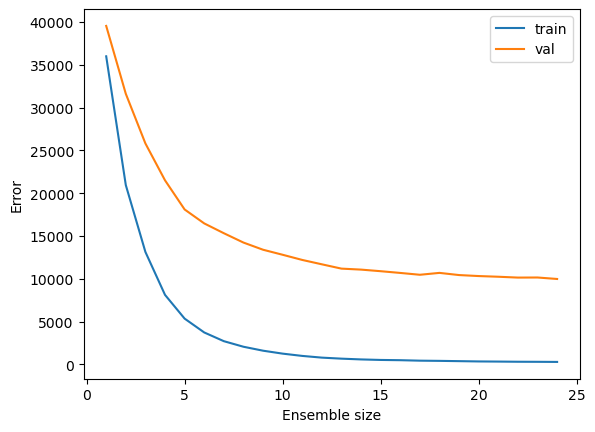

In [112]:
plt.plot(range(1, len(train_loss_log)+1), train_loss_log, label='train')
plt.plot(range(1, len(val_loss_log)+1), val_loss_log, label='val')
plt.xlabel('Ensemble size')
plt.ylabel('Error')
plt.legend()

Great job! Please, submit your solution to the grading system!